In [67]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# infection
alpha_0 = 2
alpha_1 = 1
beta_0 = 5
beta_1 = 1

# law enforcement
phi = 10
eps = 1

# define our initial parameters
city_pop = 3e5
init_protestors = 200
init_voilent = 20
init_law_enf = 10
init_removals = 0
total_law_enf = 200

# define our riot ode system as specified above
def ode(t, x):
    S, P, V, L, R = x
    dS_dt = -alpha_0 * S * P - alpha_1 * S * V
    dP_dt = alpha_0 * S * P - beta_0 * P * V - beta_1 * P
    dV_dt = beta_0 * P * V - phi * V * L + alpha_1 * S * V
    dR_dt = beta_1 * P + phi * V * L
    dL_dt = eps * V * L * (1 - L / total_law_enf)

    return np.array([dS_dt, dP_dt, dV_dt, dL_dt, dR_dt])

# define the time parameters (hours)
t0 = 0
tf = 40
t = np.linspace(t0, tf, 200)

# define the initial condition
init_S = (city_pop - (init_protestors + init_voilent + init_law_enf + init_removals)) / city_pop
init_P = init_protestors / city_pop
init_V = init_voilent / city_pop
init_L = init_law_enf / city_pop
init_R =  init_removals / city_pop
y0 = np.array([init_S, init_P, init_V, init_L, init_R])

#solve the system
sol = solve_ivp(ode, (t0, tf), y0, t_eval=np.linspace(t0, tf, 150))

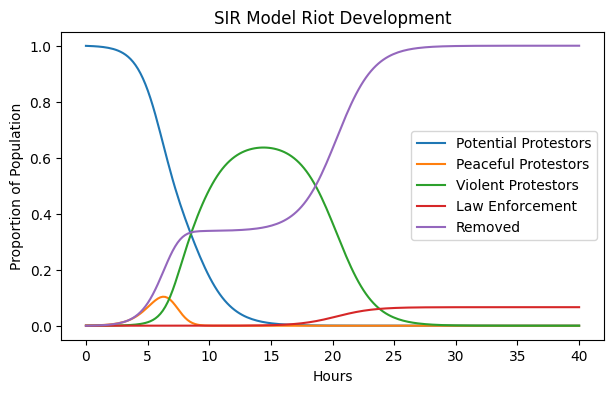

In [69]:
#solve the system
sol = solve_ivp(ode, (t0, tf), y0, t_eval=t)
# plot SIR model
plt.figure(figsize=(7, 4))
plt.plot(t, sol.y[0], label='Potential Protestors')
plt.plot(t, sol.y[1], label='Peaceful Protestors')
plt.plot(t, sol.y[2], label='Violent Protestors')
plt.plot(t, sol.y[3], label='Law Enforcement')
plt.plot(t, sol.y[4], label='Removed')
plt.xlabel("Hours")
plt.ylabel("Proportion of Population")
plt.title(f"SIR Model Riot Development")
plt.legend()
plt.show()